# **Spit some [tensor] flow**

We need to learn the intricacies of tensorflow to master deep learning

`Let's get this over with`



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
print(tf.__version__)

2.2.0


## We already have 

N = Number of Samples
D = Number of features or the dimensions 

How will we represent the time-axis? By T


Our dataset will not be N x D now, it will be N x T x D 

In TF and Keras, we usually deal with equal length sequences. Let's talk about:

## Stocks

We have one stock price so D = 1

To have a signal where D is greater than 1, we must have different inputs, e.g., GPS longitude and latitude 

T will give us the window size of area-of-interest. This is the area we look at, to predict the next value

N will be the number of windows in the time series

Thus, for a sequence of length L and a window size of T, we have N = L - T + 1

What if we have D=200, i.e., we are looking at 200 stock prices at the same time

Window size = T 
Stocks we watch = D 
Sample size = T x D 

Total samples = N = L - T + 1

We need data to be N x T x D because this is the pythonista staandard! 

We use N x D for tabular data and N x H x W x C for images; N always corresponds to the samples, D is always the number of features, H is the height, W the width and C the channels; they can either be colors, or the # of feature maps in between CNN layers



## Forecasting 

Forecasting refers to the prediction of next values in the time series. The length of prediction is the horizon i.e., if I want to predict the weather every 2 hours for the next 5 days; I will get a horizon of 5 * 24 = 120 ---> 120/2 = 60 steps


## Total windows 

For length L 10 

Window size T 4

N = L - T + 1

N = 10 - 4 + 1

N = 6 + 1

N = 7

Let's check them out! 

1 2 3 4 5 6 7 8 9 10 -------> Full sequence

```
1 2 3 4 -----> 1

  2 3 4 5 -----> 2

    3 4 5 6 -----> 3

      4 5 6 7 -----> 4

        5 6 7 8 -----> 5

          6 7 8 9 -----> 6

            7 8 9 10 -----> 7
```
But wait a minute, isn't 10 the sample number we are using as the Y variable? We can not use that, thus total number of windows = L - T =  10 - 4 = 6


## How do we predict the time series? 

Well now we're going to go into the details of the implementation; 

```
x_pred_t = w0 + w1 * x_t-1 + w2 * x_t-2 + w3 * x_t-3 + w4 * x_t-4

x_pred_t+1 = w0 + w1 * x_pred_t + w2 * x_t-1 + w3 * x_t-2 + w4 * x_t-3
```

This is an autoregressive model now. 

```
x_pred_5 = w0 + w1 * x_4 + w2 * x_3 + w3 * x_2 + w4 * x_1

x_pred_6 = w0 + w1 * x_pred_5 + w2 * x_4 + w3 * x_3 + w4 * x_2

```


In [0]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, Adamax

## Let's get some synthetic data

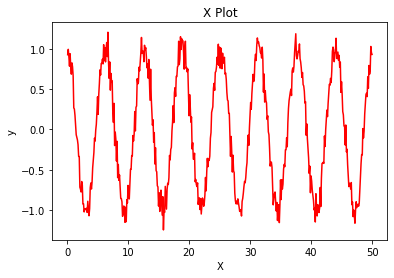

In [0]:
n = 501
x = 0.1 * np.arange(1,n)
data = np.cos(x) + np.random.randn(n-1) * 0.1

# Visualising the dataset
plt.plot(x, data, color = 'red')
plt.title('X Plot')
plt.xlabel('X')
plt.ylabel('y')
plt.show()


In [0]:
T = 40
X = []
y = []
print(len(data))  
print("The last sample would be: 500 - 10 = " + str((len(data)-T)) )
print("BUT data[1000] can not be used! so, we must go from 1 to 979 ")

500
The last sample would be: 500 - 10 = 460
BUT data[1000] can not be used! so, we must go from 1 to 979 


In [0]:
for i in range(len(data) - T):
  x = data[i:i+T]
  X.append(x)
  y_temp = data[i+T]
  y.append(y_temp)

In [0]:
X = np.array(X)
y = np.array(y)

In [0]:
print(X.shape)
print(y.shape)

N, T = X.shape

(460, 40)
(460,)


In [0]:
i_layer = Input(shape = (T, ))
o_layer = Dense(1)(i_layer)
model = Model(i_layer, o_layer)
model.compile(loss = 'mse',
              optimizer = Adam(lr = 0.3))

In [0]:
index = -N//4
report = model.fit(X[:index], y[:index], epochs=100, validation_data=(X[index:], y[index:]))

Epoch 1/100
11/11 [==============================] - 0s 7ms/step - loss: 8.6135 - val_loss: 6.3333
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 2.3468 - val_loss: 1.5458
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.8625 - val_loss: 0.1157
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 0.3940 - val_loss: 0.0839
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 0.1502 - val_loss: 0.0534
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0878 - val_loss: 0.0468
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0589 - val_loss: 0.0286
Epoch 8/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0349 - val_loss: 0.0232
Epoch 9/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0218 - val_loss: 0.0187
Epoch 10/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0201 - val_loss: 0.0185
Epoch 11/

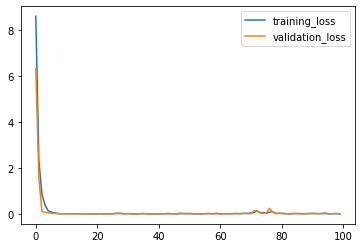

In [0]:
plt.plot(report.history['loss'], label='training_loss')
plt.plot(report.history['val_loss'], label='validation_loss')
plt.legend()

In [0]:
y_test = y[index:]
y_pred = []

In [0]:
X_end = X[index]
while len(y_pred) < len(y_test):
  pred = model.predict(X_end.reshape(1, -1))[0,0]
  y_pred.append(pred)
  X_end = np.roll(X_end, -1)
  X_end[-1] = pred

In [0]:
print(len(y_pred))
print(len(y_test))

115
115


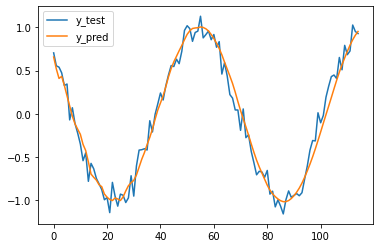

In [0]:
plt.plot(y_test, label='y_test')
plt.plot(y_pred, label='y_pred')
plt.legend()